In [1]:
import numpy as np  # Импортируем библиотеку numpy для работы с массивами чисел.
import pandas as pd  # Импортируем pandas для работы с таблицами (данными в виде таблиц).
import tensorflow as tf  # Импортируем TensorFlow для работы с нейронными сетями и машинным обучением.
import matplotlib.pyplot as plt  # Импортируем matplotlib для создания графиков.
import seaborn as sns  # Импортируем seaborn для более красивых графиков и визуализаций.
from sklearn.metrics import classification_report, confusion_matrix  # Импортируем функции для оценки модели, таких как отчёт по классификации и матрица ошибок.
import tensorflow_datasets as tfds  # Импортируем готовые наборы данных от TensorFlow для экспериментов.
from tensorflow.keras.preprocessing.text import Tokenizer  # Импортируем токенизатор для преобразования текста в числа.
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Импортируем функцию для приведения последовательностей (например, текста) к одинаковой длине.


In [2]:
# В якості домашнього завдання вам пропонується створити рекурентну нейронну мережу за допомогою механізмів Keras,
# яка буде класифікувати рецензії із датасету imdb.

# На відміну від прикладу в модулі 9 ми використаємо рекурентну нейронну мережу. Поекспериментуйте з будовою мережі - RNN, LSTM, двостороння та глибока.

# Порівняйте результати та зробіть висновки.

**Download the Dataset**

In [3]:
# Этот код загружает данные с отзывами на фильмы и метками, которые показывают, положительные отзывы или отрицательные.
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
# tfds.load загружает набор данных.
# "imdb_reviews" — это набор данных с отзывами на фильмы из IMDb (люди пишут, понравился ли им фильм).
# with_info=True — мы говорим программе, что хотим получить дополнительную информацию о данных (например, сколько в них отзывов).
# as_supervised=True — это значит, что отзывы уже разделены на текст (что человек написал) и метку (понравился фильм или нет).

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.RRHJZ3_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.RRHJZ3_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.RRHJZ3_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# выводит на экран информацию о наборе данных, который мы загрузили
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmpfgo7xxcotfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo

In [5]:
# Это ↑ описание набора данных IMDB Reviews, который содержит отзывы на фильмы.
# Всего 25,000 отзывов для обучения (train) и 25,000 для тестирования (test).
# Отзывы делятся на 2 класса: положительные и отрицательные (это показано в label).
# Есть ещё 50,000 неразмеченных отзывов, которые можно использовать для других целей (unsupervised).
# Размер набора данных: около 130 МБ.
# Этот набор данных помогает обучать модели различать хорошие и плохие отзывы о фильмах.

In [6]:
dataset_info = info  # Сохраняем информацию о датасете IMDb в переменную dataset_info

# Создаём словарь, где собираем важную информацию из dataset_info
data_dict = {
    # Pазделы данных: тренировочные, тестовые и без меток
    "Split": ["train", "test", "unsupervised"],
    # Количество примеров в каждом разделе
    "Number of Examples": [dataset_info.splits["train"].num_examples, dataset_info.splits["test"].num_examples, dataset_info.splits["unsupervised"].num_examples],
    # Информация о признаках (тексты и метки) для каждого раздела
    "Features": [dataset_info.features, dataset_info.features, dataset_info.features],
    # Метки классов для каждого раздела (положительные и отрицательные отзывы)
    "Labels": [dataset_info.features["label"].names, dataset_info.features["label"].names, dataset_info.features["label"].names],
    # Здесь можно добавить другую важную информацию, если потребуется
}

df = pd.DataFrame(data_dict)  # Превращаем словарь в таблицу (DataFrame) для удобного отображения
df  # Показываем таблицу

# Этот код создает таблицу с информацией о датасете IMDb. В таблице видно, сколько примеров есть в каждой части данных (тренировочной, тестовой и без меток),
# а также какие метки (положительные и отрицательные) присутствуют. Таблицу легко использовать для анализа данных.


,Split,Number of Examples,Features,Labels
0,train,25000,"(text, label)","[neg, pos]"
1,test,25000,"(text, label)","[neg, pos]"
2,unsupervised,50000,"(text, label)","[neg, pos]"


In [7]:
# ↑
# В датасете IMDb есть 3 части:
# в наборе данных содержится в общей сложности 100 000 примеров,
# и он разделен на обучающий, тестовый и неконтролируемый наборы:

# В тренировочных данных (train) 25,000 примеров с отзывами.
# В тестовых данных (test) тоже 25,000 примеров.
# В данных без меток (unsupervised) 50,000 примеров, где нет указано, положительные или отрицательные отзывы.
# Каждый пример состоит из текста отзыва (text) и его метки (label). Метки бывают двух видов: "neg" (негативный отзыв) и "pos" (положительный отзыв).

**Split the dataset**

In [8]:
# команда выводит на экран информацию о наборе данных imdb
print(imdb)

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('unsupervised'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [9]:
# это ↑ словарь, который показывает информацию о каждом разделе (train, test, unsupervised) в наборе данных и типах данных внутри каждого раздела.

In [10]:
# Итерация по словарю imdb
for split_name, dataset in imdb.items():
    print(f"{split_name}:")
    print(f"  Element spec: {dataset.element_spec}")
    print()  # Печатает пустую строку для разделения

train:
  Element spec: (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))

test:
  Element spec: (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))

unsupervised:
  Element spec: (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))



In [11]:
# это ↑ более читабельный формат, который выводит ту же информацию, но в более понятном виде, где указано, что каждый раздел содержит TensorSpec для текста и меток.


# Из этих выводoв можно сделать следующие выводы:

# Разделы данных: Набор данных содержит три раздела:
# train (для обучения)
# test (для проверки)
# unsupervised (неподконтрольные данные)

# Типы данных: В каждом разделе есть данные в виде текстов и меток:
# Тексты хранятся как строки (dtype=tf.string)
# Метки хранятся как целые числа (dtype=tf.int64)

# Формат данных: Каждый элемент в этих разделах представляет собой пару:
# Текстовый отзыв (который хранится как строка (tf.string))
# Его метка (положительный или отрицательный отзыв) (которая хранится как целое число (tf.int64).)


# Это значит, что набор данных готов к использованию для обучения и проверки моделей машинного обучения.

In [12]:
# код выделяет данные для обучения (train_data) и данные для тестирования (test_data) из набора данных imdb.
train_data, test_data = imdb["train"], imdb["test"]

# Возьмем 1 обучающий пример и распечатайте его содержимое
# Это поможет понять, как выглядят данные, которые будут использоваться для обучения модели.
for i in train_data.take(1):
  print(i)


(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [13]:
# Отзыв говорит, что фильм ужасный.
# Метка 0 (numpy=0) означает, что отзыв негативный.

In [14]:
# Чтобы сделать вывод более читабельным, можно преобразовать тензоры в строки и числа и отформатировать их. Вот как это можно сделать:

In [15]:
# Взять один пример из данных обучения
for i in train_data.take(1):
    # Преобразовать тензоры в обычные строки и числа
    text = i[0].numpy().decode('utf-8')  # Преобразование тензора текста в строку
    label = int(i[1].numpy())  # Преобразование тензора метки в число

    # Отобразить результат
    print(f"Текст отзыва:\n{text}\n")
    print(f"Метка отзыва: {'Положительный' if label == 1 else 'Отрицательный'}")

Текст отзыва:
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.

Метка отзыва: Отрицательный


In [16]:
# Сначала создаются списки для хранения текстов и меток из обучающего набора данных
# Инициализируем пустые списки для предложений и меток
train_sentences = []
train_labels = []

test_sentences = []
test_labels = []

# Проходим по всем примерам из обучающего набора данных и сохраняем предложения и метки
# код проходит по всем примерам в train_data, преобразует текст в строку и сохраняет его в train_sentences, а метку добавляет в train_labels.
for s, l in train_data:
  train_sentences.append(s.numpy().decode('utf-8'))  # Преобразуем текст из байтов в строку и добавляем в список
  train_labels.append(l.numpy())  # Добавляем метку в список

# Выводим первые 6 примеров из обучающего набора данных
for i, text in zip(train_labels[:6], train_sentences[:6]):
  print(f'label {i}: {text[:150]}...')  # Печатаем метку и первые 150 символов текста
# Должны увидить первые 6 текстов отзывов и их метки. Это поможет понять, как выглядят данные и какие метки у них есть (положительные или отрицательные).

label 0: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be the...
label 0: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable ...
label 0: Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem...
label 1: This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chai...
label 1: As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female...
label 1: This is a film which should be seen by anybody interested in, effected by, or suffering from an eating disorder. It is an amazingly accurate and sensi...


In [17]:
# ↑ Метка 0 — это отрицательные отзывы, а метка 1 — положительные отзывы.
# Это поможет понять, как модель будет учиться отличать хорошие фильмы от плохих на основе текста отзыва.

In [18]:
# Проход по тестовым данным:
for s, l in test_data:
  # s — это текст отзыва, а l — метка (положительная или отрицательная)
  # s.numpy().decode('utf-8') превращает текст отзыва из формата TensorFlow в обычный текст.
  # l.numpy() превращает метку в число.
  test_sentences.append(s.numpy().decode('utf-8'))
  # Эти данные сохраняются в списки test_sentences и test_labels.
  test_labels.append(l.numpy())

# Вывод первых 6 примеров:
# zip(test_labels[:6], test_sentences[:6]) объединяет метки и тексты для первых 6 примеров.
for i, text in zip(test_labels[:6], test_sentences[:6]):
  # text[:150] показывает только первые 150 символов текста, чтобы не печатать длинные отзывы полностью.
  print(f'label {i}: {text[:150]}...')

label 1: There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add...
label 1: A blackly comic tale of a down-trodden priest, Nazarin showcases the economy that Luis Bunuel was able to achieve in being able to tell a deeply human...
label 0: Scary Movie 1-4, Epic Movie, Date Movie, Meet the Spartans, Not another Teen Movie and Another Gay Movie. Making "Superhero Movie" the eleventh in a s...
label 0: Poor Shirley MacLaine tries hard to lend some gravitas to this mawkish, gag-inducing "feel-good" movie, but she's trampled by the run-away sentimental...
label 1: As a former Erasmus student I enjoyed this film very much. It was so realistic and funny. It really picked up the spirit that exists among Erasmus stu...
label 1: My God, Ryan Gosling has made a lot of deep characters in his career, this is one of his wonderful acting jobs. For me this is a very deep movie, need...


In [19]:
# Преобразование меток обучения в массив NumPy:
# train_labels — это список меток для обучающих данных.
# np.array(train_labels) преобразует этот список в массив NumPy.
# training_labels_final — это массив меток для обучающих данных.
training_labels_final = np.array(train_labels)
# Преобразование меток тестирования в массив NumPy:
# test_labels — это список меток для тестовых данных.
# np.array(test_labels) преобразует этот список в массив NumPy.
# testing_labels_final — это массив меток для тестовых данных.
testing_labels_final = np.array(test_labels)

# Подготовка данных для анализа или обучения: Преобразование меток в массивы NumPy делает их удобными для обработки и анализа.
# Массивы NumPy часто используются в машинном обучении для более быстрого и удобного выполнения математических операций.

**Function For Plot Visualization**

In [20]:
def plot_graphs(history, string):
  plt.figure(figsize=(5, 3))  # Создаем фигуру для графика
  plt.plot(history.history[string])  # Рисуем график для значения 'string' из истории обучения
  plt.plot(history.history['val_'+string])  # Рисуем график для значения 'val_' + 'string' из истории проверки
  plt.xlabel("Epochs")  # Подписываем ось X
  plt.ylabel(string) # Подписываем ось Y
  plt.legend([string, 'val_'+string]) # Добавляем легенду для графиков
  plt.show()

  # помогает понять, насколько хорошо модель учится и обобщается, и какие шаги можно предпринять для её улучшения.

**Function For Report and Confusion Matrix**

In [21]:
def report(x):
  # Предсказания и оценка модели
  predictions = x.predict(testing_padded)  # Получаем предсказания модели для тестовых данных
  x.evaluate(testing_padded, testing_labels_final)  # Оцениваем модель на тестовых данных

  # Бинаризация предсказаний:
  binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions] # Преобразуем предсказания в бинарный формат (0 или 1)

  # Показываем 10 примеров предсказанных и истинных меток
  for i in range(10):
      print(f"Predicted: {binary_predictions[i]}, Label: {1 if testing_labels_final[i] > 0.5 else 0}")

  # Печатаем отчет о классификации
  report = classification_report(testing_labels_final, binary_predictions)
  print(report)

  # Вычисляем и отображаем матрицу ошибок (Confusion Matrix)
  cm = confusion_matrix(testing_labels_final, binary_predictions)
  confusion_df = pd.DataFrame(columns=["Positive", "Negative"],
                              index=["Positive", "Negative"],
                              data=cm)

  # Создаем тепловую карту (heatmap) для матрицы ошибок
  f, ax = plt.subplots(figsize=(4,4))
  sns.heatmap(confusion_df, annot=True, cmap="Reds", fmt='d', ax=ax)
  plt.xlabel("Predicted Label")
  plt.xticks(size=12)
  plt.yticks(size=12, rotation=0)
  plt.ylabel("Actual Label")
  plt.title("Confusion Matrix", size=14)
  plt.show()

  # Печатаем количество истинно положительных (TP), истинно отрицательных (TN),
  # ложно положительных (FP) и ложно отрицательных (FN) примеров
  print("TP:", (cm[0,0]))
  print("TN:", (cm[1,1]))
  print("FP:", (cm[0,1]))
  print("FN:", (cm[1,0]))

  # Отображаем тепловую карту
  plt.show()
# Мы можем оценить, насколько хорошо модель предсказывает метки и сравнивает предсказания с истинными метками.
# Графики и матрица ошибок помогают понять, где модель ошибается и как её можно улучшить.

In [22]:
vocab_size = 10000  # Максимальное количество уникальных слов в словаре, который будем использовать.
max_length = 120  # Максимальная длина последовательности (текстового отзыва)(Длина текста, до которой будем обрезать или дополнять наши последовательности.)
embedding_dim = 32  # Размерность векторного представления слов (будет использоваться в модели)
trunc_type = 'post'  # Как обрезать длинные последовательности (обрезать в конце),(Как обрезать последовательности, если они длиннее max_length.)
oov_tok = ""  # Токен для неизвестных слов (в этом случае он пустой)
BATCH_SIZE=128  # Размер батча для обучения модели
NUM_EPOCHS = 5  # Количество эпох для обучения модели

# Инициализируем класс Tokenizer
# Создаем объект Tokenizer, который будет работать с ограниченным словарем и с токеном для неизвестных слов.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Создаем словарь индексов слов на основе тренировочных предложений
tokenizer.fit_on_texts(train_sentences)
# Получаем словарь, где каждому слову соответствует уникальный индекс.
word_index = tokenizer.word_index

# Преобразуем текстовые отзывы в последовательности чисел и добавляем паддинг (дополняем до одной длины)
# Преобразуем тренировочные предложения в числовые последовательности.
sequences = tokenizer.texts_to_sequences(train_sentences)
# Дополняем или обрезаем последовательности до max_length.
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

# Преобразуем тестовые отзывы в последовательности чисел и добавляем паддинг
# Преобразуем тестовые предложения в числовые последовательности.
testing_sequences = tokenizer.texts_to_sequences(test_sentences)
# Дополняем или обрезаем тестовые последовательности до max_length.
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

# Мы подготовили текстовые данные для модели, преобразовав их в числовой формат и приведя их к одной длине.
# Эти данные можно использовать для обучения модели машинного обучения или нейронной сети.

In [23]:
# testing_padded: Это массив с тестовыми последовательностями, где каждая последовательность преобразована в числовой формат и дополнена или обрезана до одной длины.
print(testing_padded[-1]) # Выводит последнюю последовательность в массиве testing_padded.

# Код покажет последнюю тестовую последовательность после преобразования и паддинга.
# Это может помочь проверить, как последний текст был преобразован и дополнен.

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   34   41
   90   95 2466   38   34  341    6   12   29   67 2207   85  103    3
    2  831 3144    5  542  118 2714  124 6521   16    4 7608 1070  121
   12  129 1287   15   29    5    2 4098 1147 7608 1070  285    3   29
    5    2   89    1 1574  448 8608 2127]


In [24]:
# Этот ↑ вывод представляет собой последовательность чисел, где:
# 0: Места, которые были заполнены нулями, потому что текст был короче заданной длины (в нашем случае 120 слов).
# Другие числа: Это индексы слов из словаря, которые были преобразованы в числовой формат.

# Последняя последовательность из тестовых данных была преобразована в числовой формат и дополнена нулями до длины 120.
# Места с нулями означают, что текст был короче и заполнялся нулями.
# Остальные числа представляют собой индексы слов из словаря, где каждое число соответствует конкретному слову в тексте.

In [25]:
# Колбэк для ранней остановки
epoch_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',  # Следим за метрикой 'accuracy' (точность)
    patience=10,         # Если точность не улучшается в течение 10 эпох, остановим обучение
    verbose=1,           # Печатаем сообщения о процессе остановки
    mode='auto',         # Автоматически выбираем режим для метрики (увеличение или уменьшение)
    restore_best_weights=False  # Не восстанавливаем лучшие веса модели
)

# Колбэк для уменьшения скорости обучения
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Следим за метрикой 'val_accuracy' (точность на валидации)
    factor=0.2,              # Уменьшаем скорость обучения в 5 раз, когда точность не улучшается
    patience=2               # Если точность не улучшается в течение 2 эпох, уменьшаем скорость обучения
)
# Ранняя остановка: Если точность модели не улучшается долго (10 эпох), обучение остановится. Это помогает избежать переобучения и экономит время.
# Уменьшение скорости обучения: Если точность на валидации не улучшается (2 эпохи), скорость обучения уменьшается в 5 раз.
# Это помогает модели лучше обучаться, когда она достигает плато в обучении.

In [26]:
# Подытожим что мы сделали до етого момента:
# Загрузили датасет:
# Мы загрузили набор данных IMDB с отзывами о фильмах, который содержит отзывы и их метки (положительные или отрицательные).

# Просмотрели информацию о датасете:
# Проверили, сколько примеров в обучающем, тестовом и неаннотированном наборах данных.

# Разделили данные на тренировочные и тестовые:
# Разделили отзывы и метки на обучающие и тестовые наборы данных.

# Преобразовали текст в числа(Токенизация):
# Преобразовали текстовые отзывы в числовые последовательности, которые могут использоваться для обучения модели.
# (Тексты преобразуются в числовые последовательности с помощью Tokenizer.)

# Добавили нули для одинаковой длины:
# Привели все числовые последовательности к одинаковой длине, добавляя нули в конце, если необходимо.
# (Дополнение и обрезка: Последовательности слов дополнены до одной длины и обрезаны, если они слишком длинные.)

# Определили колбэки для обучения модели:
# Настроили колбэки для ранней остановки и уменьшения скорости обучения, чтобы улучшить процесс обучения и избежать переобучения.

# Мы подготовили данные для обучения модели, преобразовали текстовые отзывы в числовой формат и настроили параметры для более эффективного обучения модели.

In [27]:
# Теперь ⬇️ создадим и обучим разные типы рекуррентных нейронных сетей, чтобы сравнить их эффективность.
# В каждом случае модель будет обучается на тех же данных, а результаты мы будем сравнивають, чтобы выбрать наилучший подход для классификации рецензий.

# Будем использовать:

# Flatten: Преобразует многомерные данные в одномерный вектор для последующего использования в полносвязных слоях. Он не учитывает последовательные зависимости.

# LSTM: Захватывает долгосрочные зависимости в тексте и может лучше понимать контекст.

# GRU: Похож на LSTM, но проще и быстрее.

# Convolution RNN: Комбинирует свёртки и рекуррентные слои для лучшего извлечения признаков из текста.

# SRNN: Простейший тип рекуррентной сети, может не справляться с сложными текстами.

# BRNN: Использует рекуррентные слои в обоих направлениях для учета контекста с обеих сторон текста.

# Deep BRNN: Расширяет BRNN, добавляя несколько слоев для более глубокого анализа текста.

**Flatten**

Сначала просто используем слой Flatten после встраивания. Его главное преимущество в том, что он очень быстро тренируется.

In [28]:
# Создаем модель с помощью Keras
model = tf.keras.Sequential([
    # Слой Embedding для преобразования слов в векторы фиксированной длины
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    # Преобразуем многомерные данные в одномерный вектор
    tf.keras.layers.Flatten(),
    # Полносвязный слой с активацией sigmoid для бинарной классификации
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Настраиваем параметры для обучения модели. Используется функция потерь binary_crossentropy, оптимизатор adam, и метрика accuracy.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Пример входных данных для проверки модели. input_example создаёт случайные данные для проверки, как модель обрабатывает входные данные.
input_example = np.random.randint(0, vocab_size, (1, max_length))

# Создаем выход модели на основе примера входных данных (model(input_example) проверяет, как модель работает с примером входных данных.)
model(input_example)

# Печатаем сводку модели, чтобы увидеть её структуру
model.summary()

# Модель создана и готова для обучения.
# Можно увидеть, как модель принимает входные данные и какие слои у неё есть.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 120, 32)                │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 3840)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 1)                      │           3,841 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,841 (1.24 MB)

 Trainable params: 323,841 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# ❗❗❗
# у меня выдавало:
#  Total params: 0 (0.00 B)
#  Trainable params: 0 (0.00 B)
#  Non-trainable params: 0 (0.00 B)
# чат сказал добавить:
# Примерные входные данные для создания модели
input_example = np.random.randint(0, vocab_size, (1, max_length))

# Постройте модель на основе этих данных
# model_lstm(input_example)
model(input_example)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49535704]], dtype=float32)>

In [30]:
# Печатаем сводку модели, чтобы увидеть её структуру
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 120, 32)                │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 3840)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 1)                      │           3,841 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,841 (1.24 MB)

 Trainable params: 323,841 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# ↑
# Embedding слой: Преобразует входные данные (векторы слов) в 32-мерные векторы. Размер выходных данных этого слоя: (1, 120, 32). Это означает, что на вход поступает последовательность из 120 слов, каждое из которых представлено вектором длиной 32.

# Flatten слой: Преобразует многомерный выход из слоя Embedding в одномерный вектор. Размер выходных данных этого слоя: (1, 3840). Это означает, что все векторы слов объединяются в один длинный вектор длиной 3840.

# Dense слой: Полносвязный слой, который преобразует одномерный вектор в выходной вектор длиной 1. Он используется для классификации (например, для бинарной классификации).

# Параметры:

# Embedding: 320,000 параметров. Это число зависит от размера словаря и размера векторов слов.
# Dense: 3,841 параметр. Это количество параметров для весов и смещений в полносвязном слое.
# Вся модель содержит 323,841 параметров, которые будут обучаться во время тренировки.

In [32]:
# Обучение модели
history = model.fit(
    padded,  # Входные данные для обучения модели (тренировочные данные).
    training_labels_final,  # Метки (правильные ответы) для тренировочных данных.
    epochs=NUM_EPOCHS,  # Сколько раз модель будет обучаться на всех данных (NUM_EPOCHS - это число эпох).
    batch_size=128,  # Размер группы данных, которая обрабатывается за один раз (батч).
    validation_data=(testing_padded, testing_labels_final),  # Данные для проверки качества модели во время обучения.
    callbacks=[reduce_lr, epoch_callback]  # Функции обратного вызова для изменения обучения (например, уменьшение скорости обучения).
)
# Обучение: Модель будет обучаться на данных padded и training_labels_final.
# Эпохи: Модель пройдет через данные 5 раз (сколько указано в NUM_EPOCHS).
# Батч: Данные будут разделены на группы по 128 примеров для обработки.
# Проверка: Во время обучения модель будет проверяться на данных testing_padded и testing_labels_final.
# Функции обратного вызова: Используются для автоматического уменьшения скорости обучения и для раннего остановки, если модель перестает улучшаться.
# Модель будет тренироваться и проверяться на данных, а результаты обучения можно отслеживать и анализировать.

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5799 - loss: 0.6702 - val_accuracy: 0.8003 - val_loss: 0.4599 - learning_rate: 0.0010
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8489 - loss: 0.3764 - val_accuracy: 0.8255 - val_loss: 0.3879 - learning_rate: 0.0010
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9078 - loss: 0.2544 - val_accuracy: 0.8323 - val_loss: 0.3722 - learning_rate: 0.0010
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9455 - loss: 0.1837 - val_accuracy: 0.8318 - val_loss: 0.3813 - learning_rate: 0.0010
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9699 - loss: 0.1254 - val_accuracy: 0.8302 - val_loss: 0.3973 - learning_rate: 0.0010


In [33]:
# ↑
# Точность (accuracy): Улучшается с каждой эпохой. Модель становится более точной, и её способность правильно классифицировать увеличивается.
# Потери (loss): Уменьшаются с каждой эпохой, что означает, что модель становится лучше в предсказаниях.

# Точность на проверочных данных (val_accuracy): Меняется незначительно, но в целом остаётся на высоком уровне. Это хорошо, потому что модель хорошо работает на новых данных.
# Потери на проверочных данных (val_loss): Немного увеличиваются, что может указывать на то, что модель начинает переобучаться
# или её точность на новых данных может немного снизиться.

# Скорость обучения (learning_rate):  Остаётся постоянной (0.001) в течение всех эпох, что означает, что скорость обучения не менялась во время обучения.

# В общем, модель обучается хорошо, её точность растёт, но есть небольшие колебания в потерь на проверочных данных.

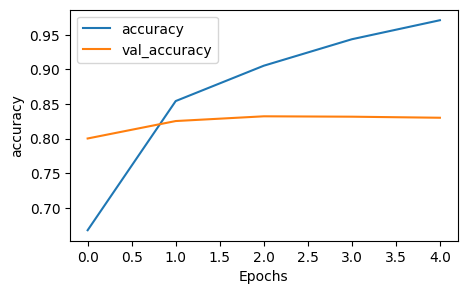

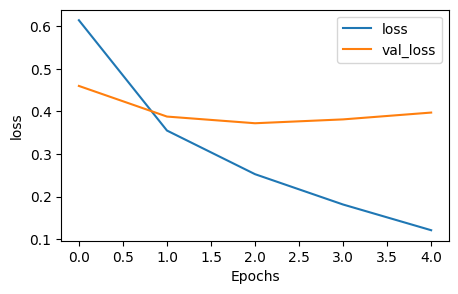

In [34]:
plot_graphs(history, 'accuracy')  # Построение графика точности
plot_graphs(history, 'loss')      # Построение графика потерь

# График точности покажет, насколько хорошо модель обучалась. Если линия растёт, это значит, что модель становилась лучше.
# График потерь покажет, насколько хорошо модель уменьшают свои ошибки. Если линия падает, это значит, что модель делает меньше ошибок.
# Эти графики помогают понять, как модель обучалась и какие результаты были достигнуты.

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8347 - loss: 0.3926
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     12500
           1       0.84      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



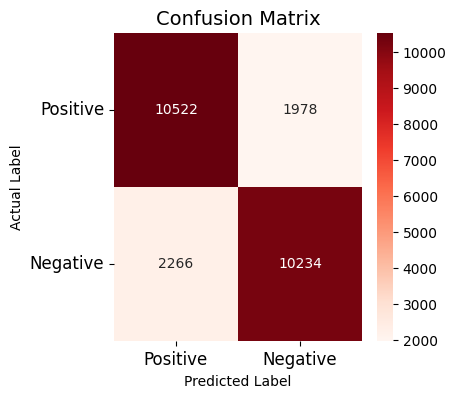

TP: 10522
TN: 10234
FP: 1978
FN: 2266


In [35]:
# Этот код вызывает функцию report, которая проверяет, как хорошо модель работает после обучения.
report(model)

# Внутри функции report происходит следующее:
# Модель делает предсказания для тестовых данных.
# Модель оценивает свои ошибки на тестовых данных.
# Предсказания преобразуются в бинарные значения (0 или 1).
# Печатаются сравнения предсказаний и настоящих значений.
# Создаются и отображаются матрица ошибок (confusion matrix) и её тепловая карта (heatmap).

In [36]:
# ↑
# Точность (accuracy) модели на тестовых данных — 83.47%. Это значит, что модель правильно предсказала 82.86% рецензий.

# Большинство предсказаний совпадают с реальными метками.
# Есть несколько ошибок: например, предсказано 1, а реальная метка 0 (и наоборот).

# Оценка качества (отчет):
  # Precision (точность): Как часто модель правильно предсказывает класс 0 и 1.
    # Для класса 0: 82%
    # Для класса 1: 84%
  # Recall (полнота): Как хорошо модель находит все примеры класса 0 и 1.
    # Для класса 0: 84%
    # Для класса 1: 82%
  # F1-score: Среднее значение precision и recall. Хорошо сбалансированное значение для обоих классов.

# Матрица ошибок (confusion matrix):
  # TP (True Positives): 10522. Верно предсказаны позитивные рецензии.
  # TN (True Negatives): 10234. Верно предсказаны негативные рецензии.
  # FP (False Positives): 1978. Негативные рецензии предсказаны как позитивные.
  # FN (False Negatives): 2266. Позитивные рецензии предсказаны как негативные.

# Модель в целом хорошо работает, но есть небольшие ошибки. Сбалансированное качество предсказаний для двух классов.

**LSTM(Long Short-Term Memory)**

In [37]:
# Этот код помогает создать и настроить модель для работы с текстом, используя слой LSTM для обработки последовательностей.

embedding_dim = 16  # Размерность векторов для представления слов (В Embedding слое создаются векторы размером 16 для каждого слова.)
lstm_dim = 32       # Количество нейронов в слое LSTM (LSTM слой использует 32 нейрона для обработки текста.)
dense_dim = 6       # Количество нейронов в скрытом слое Dense

# Определение модели с использованием LSTM
model_lstm = tf.keras.Sequential([
    # Слой для преобразования слов в векторы фиксированной длины
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

    # LSTM слой для обработки последовательностей
    tf.keras.layers.LSTM(lstm_dim),

    # Полносвязный слой для получения конечного предсказания
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Настройка параметров для обучения модели
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Примерные входные данные для проверки модели
input_example = np.random.randint(0, vocab_size, (1, max_length))

# Построение модели на основе входных данных
model_lstm(input_example)

# Печать информации о модели
model_lstm.summary()

# Модель сначала превращает слова в векторы (слой Embedding),
# затем обрабатывает последовательность с помощью LSTM, и в конце делает предсказание с помощью полносвязного слоя (Dense).


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (1, 120, 16)                │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (1, 32)                     │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,305 (649.63 KB)

 Trainable params: 166,305 (649.63 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# ↑
# Embedding: Входные данные преобразуются в векторы размером 16 для каждого слова. Выход имеет размер (1, 120, 16), где 120 — это длина последовательности слов.
# LSTM: После обработки последовательности LSTM возвращает вектор размером 32. Это выход (1, 32).
# Dense: Полносвязный слой (Dense) выдает результат с одним значением (1, 1).

# Embedding: 160,000 параметров (для преобразования слов в векторы).
# LSTM: 6,272 параметра (для обработки последовательностей).
# Dense: 33 параметра (для окончательного предсказания).

# Общее количество параметров: 166,305. Все параметры можно обучать.
# Размер модели: 649.63 KB.
# Модель имеет три слоя, где первый преобразует слова в векторы, второй обрабатывает последовательности, а третий делает предсказание.

In [39]:
# Этот код запускает процесс обучения модели LSTM.
history_lstm = model_lstm.fit(
    padded,
    training_labels_final,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(testing_padded, testing_labels_final),
    callbacks=[epoch_callback, reduce_lr]
    )
# Этот код запускает обучение модели. По окончании каждой эпохи мы сможем увидеть,
# насколько модель улучшает свои предсказания, сравнивая ошибки и точность на тренировочных и тестовых данных.

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.6088 - loss: 0.6238 - val_accuracy: 0.8171 - val_loss: 0.4112 - learning_rate: 0.0010
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.8699 - loss: 0.3200 - val_accuracy: 0.8282 - val_loss: 0.4151 - learning_rate: 0.0010
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.9063 - loss: 0.2495 - val_accuracy: 0.8128 - val_loss: 0.4361 - learning_rate: 0.0010
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.9266 - loss: 0.2018 - val_accuracy: 0.8140 - val_loss: 0.4492 - learning_rate: 0.0010
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.9474 - loss: 0.1624 - val_accuracy: 0.8152 - val_loss: 0.5000 - learning_rate: 2.0000e-04


In [40]:
# ↑
# Точность на тренировочных данных: Модель учится хорошо — точность увеличивается с 60.88% до 94.74% за 5 эпох.
# Ошибка на проверочных данных: Хотя точность модели на тренировочных данных высокая, на проверочных данных она держится около 82%.
#   Это может означать, что модель немного переобучилась.
# Скорость обучения: В конце обучения скорость (learning_rate) была уменьшена, чтобы модель училась медленнее и точнее.

# Модель учится хорошо, но нужно быть внимательным к проверочным данным, так как результаты могут указывать на переобучение.

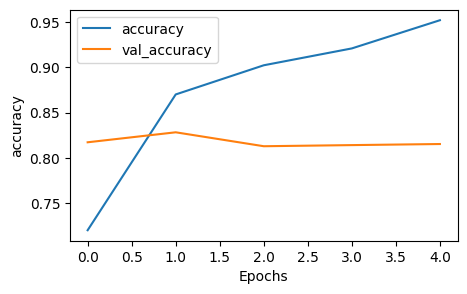

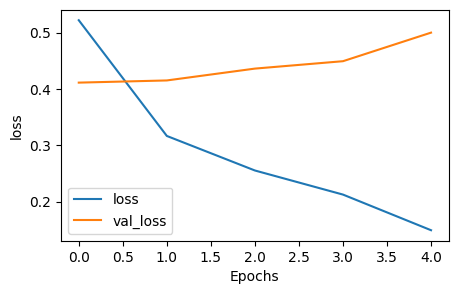

In [41]:
# Эти строки строят два графика. Один показывает, как улучшалась точность модели, другой — как уменьшалась ошибка (потери).
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

# График точности покажет, насколько хорошо модель обучалась. Если линия растёт, это значит, что модель становилась лучше.
# График потерь покажет, насколько хорошо модель уменьшают свои ошибки. Если линия падает, это значит, что модель делает меньше ошибок.
# Эти графики помогают понять, как модель обучалась и какие результаты были достигнуты.

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8186 - loss: 0.4942
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.80      0.85      0.82     12500
           1       0.84      0.78      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.81     25000
weighted avg       0.82      0.82      0.81     25000



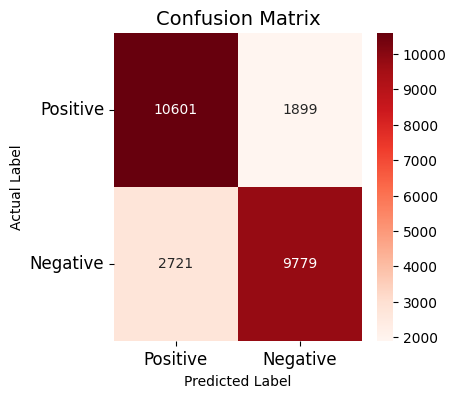

TP: 10601
TN: 9779
FP: 1899
FN: 2721


In [42]:
report(model_lstm)

In [43]:
# ↑
# Точность модели составляет 82%. Это значит, что из 100 рецензий модель правильно классифицирует 82.
# Precision и Recall для обоих классов (0 и 1) примерно равны, что говорит о сбалансированности модели. Модель хорошо предсказывает как положительные, так и отрицательные рецензии.
# TP (True Positives) — 10601: это случаи, когда модель правильно предсказала положительные рецензии.
# TN (True Negatives) — 9779: это случаи, когда модель правильно предсказала отрицательные рецензии.
# FP (False Positives) — 1899: это случаи, когда модель ошибочно посчитала отрицательные рецензии положительными.
# FN (False Negatives) — 2721: это случаи, когда модель ошибочно пропустила положительные рецензии.
# Модель работает неплохо, но иногда ошибается, особенно при распознавании отрицательных рецензий.

**GRU(Gated Recurrent Unit)**

In [44]:
# Параметры для слоев модели
embedding_dim = 16  # Размерность векторного представления слов (Embedding)
gru_dim = 32  # Количество нейронов в слое GRU
dense_dim = 6  # Количество нейронов в слое Dense (обычный слой)

# Определение модели с GRU
model_gru = tf.keras.Sequential([
    # Слой, который преобразует слова в векторы
    tf.keras.layers.Embedding(vocab_size, embedding_dim),

    # Двухнаправленный GRU слой, который может обрабатывать информацию в обе стороны
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),

    # Обычный плотный слой с 6 нейронами, который помогает учить сложные зависимости
    tf.keras.layers.Dense(dense_dim, activation='relu'),

    # Последний слой: один нейрон для предсказания 0 или 1 (плохая или хорошая рецензия)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Устанавливаем параметры для обучения модели
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Пример данных для запуска модели (рандомные данные для примера)
input_example = np.random.randint(0, vocab_size, (1, max_length))

# Строим модель на этих данных, чтобы она знала, какие размеры использовать
model_gru(input_example)

# Выводим информацию о слоях модели
model_gru.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, 120, 16)                │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (1, 64)                     │           9,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 6)                      │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 1)                      │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,997 (664.05 KB)

 Trainable params: 169,997 (664.05 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# ↑
# Из этого вывода можно сказать, что модель довольно простая, но мощная:

# Первый слой (Embedding): превращает слова в числа размерностью 16 (160,000 параметров для этого).
# Второй слой (Bidirectional GRU): обрабатывает информацию в двух направлениях (слева направо и справа налево), содержит 9,600 параметров.
# Третий слой (Dense): слой с 6 нейронами, который помогает анализировать данные (390 параметров).
# Четвертый слой (Dense): один выход для предсказания (0 или 1 — плохая или хорошая рецензия), всего 7 параметров.
# Модель небольшая, около 170,000 параметров, и все они обучаемые.

In [46]:
# Этот код запускает процесс обучения модели
history_gru = model_gru.fit(padded,
                            training_labels_final,
                            batch_size=BATCH_SIZE,
                            epochs=NUM_EPOCHS,
                            validation_data=(testing_padded, testing_labels_final))

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.5549 - loss: 0.6701 - val_accuracy: 0.7688 - val_loss: 0.4853
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.8299 - loss: 0.3981 - val_accuracy: 0.8288 - val_loss: 0.3974
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 44s 201ms/step - accuracy: 0.8878 - loss: 0.2910 - val_accuracy: 0.8249 - val_loss: 0.4002
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.9113 - loss: 0.2419 - val_accuracy: 0.8180 - val_loss: 0.4263
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 43s 212ms/step - accuracy: 0.9342 - loss: 0.1910 - val_accuracy: 0.8168 - val_loss: 0.4697


In [47]:
# ↑
# Тренировка:
# Модель улучшалась с каждой эпохой, достигая точности 93.42% на обучающих данных.
# Потери (loss) уменьшались, что означает, что модель лучше справляется с задачей.

# Валидация:
# Точность на валидационных данных (на тестах) немного колебалась, начиная с 76.88%, повысилась до 82.88 и снизилась до 81.68%.
# Потери на валидационных данных сначала снижались, но потом начали расти, что может указывать на переобучение
# (модель слишком хорошо запомнила тренировочные данные и хуже обобщает на новых данных).

# Таким образом, модель работает хорошо на тренировочных данных, но её эффективность на новых данных может быть немного ниже.

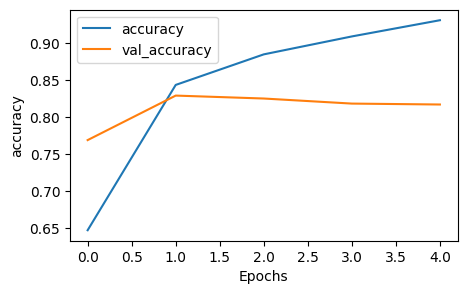

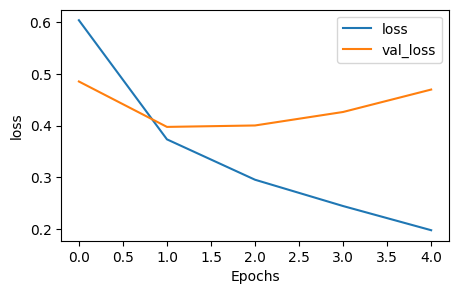

In [48]:
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

# График точности покажет, насколько хорошо модель обучалась. Если линия растёт, это значит, что модель становилась лучше.
# График потерь покажет, насколько хорошо модель уменьшают свои ошибки. Если линия падает, это значит, что модель делает меньше ошибок.
# Эти графики помогают понять, как модель обучалась и какие результаты были достигнуты.

782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8217 - loss: 0.4620
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.80      0.84      0.82     12500
           1       0.83      0.79      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



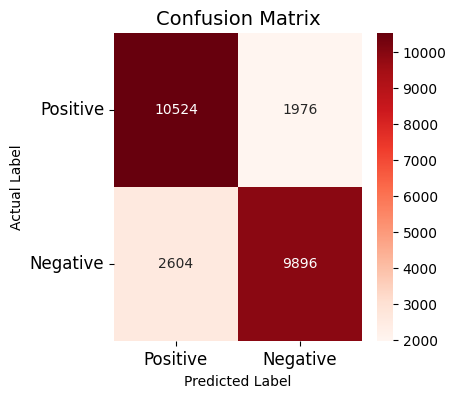

TP: 10524
TN: 9896
FP: 1976
FN: 2604


In [49]:
report(model_gru)

In [50]:
# ↑
# Точность модели:
# Модель правильно определяет положительные рецензии (True Positives, TP) в 10524 случаях.
# Модель правильно определяет отрицательные рецензии (True Negatives, TN) в 9896 случаях.
# Ошибается, когда положительная рецензия определяется как отрицательная (False Positives, FN) в 1976 случаях.
# Ошибается, когда отрицательная рецензия определяется как положительная (False Negatives, FP) в 2604 случаях.

# Метрики:
# Точность (Accuracy): 81.17% — модель правильно классифицирует 81.17% рецензий.
# Precision для положительных рецензий: 83% — точность распознавания положительных рецензий.
# Recall для отрицательных рецензий: 84% — полнота распознавания отрицательных рецензий.
# F1-score: 82% — средняя мера качества модели.

# Проблемы:
# Модель имеет проблемы с ошибками (False Negatives) при распознавании отрицательных рецензий, что может повлиять на её общую эффективность.

**Convolution RNN**

In [51]:
# Задаем параметры
embedding_dim = 16  # Размерность векторов для слов
filters = 128        # Количество фильтров для Conv1D
kernel_size = 5      # Размер ядра свертки
dense_dim = 6        # Размерность для полносвязного слоя

# Определяем модель с Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),  # Преобразуем слова в векторы
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),  # Применяем свертку
    tf.keras.layers.GlobalAveragePooling1D(),  # Уменьшаем размерность данных
    tf.keras.layers.Dense(dense_dim, activation='relu'),  # Полносвязный слой
    tf.keras.layers.Dense(1, activation='sigmoid')  # Выходной слой для бинарной классификации
])

# Настраиваем параметры обучения
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Пример входных данных для создания модели
input_example = np.random.randint(0, vocab_size, (1, max_length))

# Создаем модель на основе этих данных
model_conv(input_example)

# Печатаем сводку модели
model_conv.summary()

# Модель использует сверточные слои для извлечения признаков из текстовых данных, затем обрабатывает их через полносвязные слои для классификации.
#  Она хорошо подходит для обработки текстовых данных и предсказания категорий.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (1, 120, 16)                │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (1, 116, 128)               │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (1, 128)                    │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 6)                      │             774 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 1)                      │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# ↑
# Embedding слой превращает слова в векторы размером 16, добавляет 160,000 параметров.
# Conv1D слой применяет фильтры к тексту, добавляет 10,368 параметров.
# GlobalAveragePooling1D слой сокращает данные до размера 128 без добавления новых параметров.
# Dense слои добавляют 774 и 7 параметров соответственно.

# Модель имеет 171,149 параметров, все из которых обучаемые.

# Модель имеет разумное количество параметров для текста и должна хорошо работать на текстовых данных.

In [53]:
# Этот код запускает процесс обучения модели
history_conv = model_conv.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final), callbacks=[reduce_lr])

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.6386 - loss: 0.6279 - val_accuracy: 0.8244 - val_loss: 0.3930 - learning_rate: 0.0010
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8720 - loss: 0.3148 - val_accuracy: 0.8315 - val_loss: 0.3783 - learning_rate: 0.0010
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9063 - loss: 0.2419 - val_accuracy: 0.8246 - val_loss: 0.4097 - learning_rate: 0.0010
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9219 - loss: 0.2093 - val_accuracy: 0.8150 - val_loss: 0.4529 - learning_rate: 0.0010
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9434 - loss: 0.1709 - val_accuracy: 0.8231 - val_loss: 0.4420 - learning_rate: 2.0000e-04


In [54]:
# ↑
# Модель становится лучше с каждой эпохой, точность (accuracy) растёт, а ошибка (loss) уменьшается.
# В начале точность на тренировочных данных была 63.86%, а на последних эпохах достигла 94.34%.
# Точность на валидационных данных тоже улучшилась, но последние значения немного снизились (до 82.31%).

# Ошибка на валидационных данных увеличилась на последних эпохах, что может говорить о переобучении (overfitting).
# Это значит, что модель хорошо учится на тренировочных данных, но хуже на новых данных.

# Модель хорошо обучается, но возможно переобучается на тренировочных данных. Может понадобиться больше внимания к предотвращению переобучения.

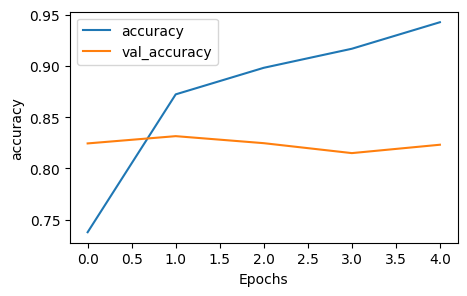

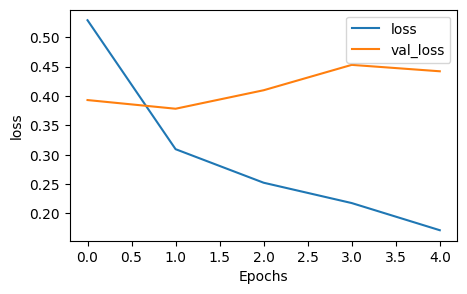

In [55]:
plot_graphs(history_conv, "accuracy")
plot_graphs(history_conv, "loss")

# График точности покажет, насколько хорошо модель обучалась. Если линия растёт, это значит, что модель становилась лучше.
# График потерь покажет, насколько хорошо модель уменьшают свои ошибки. Если линия падает, это значит, что модель делает меньше ошибок.
# Эти графики помогают понять, как модель обучалась и какие результаты были достигнуты.

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8247 - loss: 0.4396
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.82      0.83      0.82     12500
           1       0.82      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



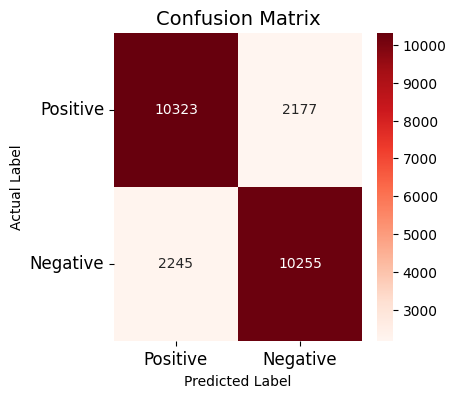

TP: 10323
TN: 10255
FP: 2177
FN: 2245


In [56]:
report(model_conv)

In [57]:
# ↑
# Точность модели (Accuracy): Модель правильно предсказывает 82.47% случаев.

# Precision (Точность):
#   Для класса 0: 82% из всех предсказанных 0 верны.
#   Для класса 1: 82% из всех предсказанных 1 верны.

# Recall (Полнота):
#   Для класса 0: 83% из всех реальных 0 модель правильно определяет.
#   Для класса 1: 82% из всех реальных 1 модель правильно определяет.

# F1-score: Это среднее между точностью и полнотой. Оба класса имеют F1-score 0.82.
# TP (Истинные положительные): Модель правильно определила 10323 примера класса 1.
# TN (Истинные отрицательные): Модель правильно определила 10255 примера класса 0.
# FP (Ложные положительные): Модель ошибочно определила 2177 примеров класса 0 как класс 1.
# FN (Ложные отрицательные): Модель ошибочно определила 2245 примеров класса 1 как класс 0.

# Модель работает хорошо, но есть возможность улучшить её, уменьшив количество ложных отрицательных и ложных положительных.

**Simple Recurrent Neural Networks (SRNNs)**

In [58]:
# Определяем параметры модели
max_features = 20000  # Максимальное количество слов в словаре
maxlen = 120          # Максимальная длина входных последовательностей
embedding_vector_length = 32  # Размерность векторных представлений слов

# Определение модели
model_srnn = tf.keras.Sequential([  # Создаем модель с помощью Sequential
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length),  # Слой для векторного представления слов
    tf.keras.layers.Dropout(0.25),  # Слой Dropout для уменьшения переобучения
    tf.keras.layers.SimpleRNN(32),  # Рекуррентный слой SimpleRNN с 32 единицами
    tf.keras.layers.Dense(units=256, activation='relu'),  # Полносвязный слой с 256 нейронами и функцией активации ReLU
    tf.keras.layers.Dropout(0.25),  # Еще один слой Dropout
    tf.keras.layers.Dense(units=1, activation='sigmoid')  # Полносвязный выходной слой с одной единицей и сигмоидной активацией
])

# Устанавливаем параметры для обучения модели
model_srnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])  # Функция потерь и оптимизатор для бинарной классификации

# Примерные входные данные для создания модели
input_example = np.random.randint(0, vocab_size, (1, max_length))  # Создаем пример входных данных

# Построение модели на основе этих данных
model_srnn(input_example)  # Прогоняем примерные данные через модель

# Печатаем сводку модели
model_srnn.summary()  # Выводим информацию о слоях и параметрах модели

# Модель: Это рекуррентная нейронная сеть (RNN) с дополнительными полносвязными слоями. Она принимает последовательности длиной 120 слов и обрабатывает их с помощью SimpleRNN.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (1, 120, 32)                │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 120, 32)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 256)                    │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, 1)                      │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 650,785 (2.48 MB)

 Trainable params: 650,785 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# ↑
# Embedding Layer:
# Размер выходных данных: (1, 120, 32)
# Параметров: 640,000
# Этот слой преобразует слова в векторы длиной 32.

# Dropout Layers:
# Эти слои не добавляют параметров.
# Используются для предотвращения переобучения.

# SimpleRNN Layer:
# Размер выходных данных: (1, 32)
# Параметров: 2,080
# Этот слой обрабатывает последовательности и запоминает информацию.

# Dense Layers:
# Первый полносвязный слой:
# Размер выходных данных: (1, 256)
# Параметров: 8,448
# Второй полносвязный слой (выходной слой):
# Размер выходных данных: (1, 1)
# Параметров: 257

# Итог:
# Всего параметров: 650,785
# Обучаемые параметры: 650,785
# Модель обрабатывает текст, создавая векторные представления слов, затем использует RNN для анализа последовательностей
# и делает финальное предсказание с помощью полносвязных слоев. Модель предназначена для обработки текста и бинарной классификации.

In [60]:
# Этот код запускает процесс обучения модели
history_srnn = model_srnn.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final),
                              callbacks=[reduce_lr, epoch_callback])

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.5217 - loss: 0.6885 - val_accuracy: 0.7700 - val_loss: 0.5045 - learning_rate: 0.0010
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.8118 - loss: 0.4322 - val_accuracy: 0.7782 - val_loss: 0.4683 - learning_rate: 0.0010
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.8892 - loss: 0.2857 - val_accuracy: 0.8140 - val_loss: 0.4622 - learning_rate: 0.0010
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9303 - loss: 0.1867 - val_accuracy: 0.7838 - val_loss: 0.5651 - learning_rate: 0.0010
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9549 - loss: 0.1160 - val_accuracy: 0.8068 - val_loss: 0.6933 - learning_rate: 0.0010


In [61]:
# ↑
# Точность (accuracy) растет с каждым эпохой, начиная с 52.17% и достигая 95.49%.
# Потери (loss) уменьшаются с каждой эпохой, что хорошо, так как это значит, что модель становится лучше.

# Точность на валидационных данных немного колеблется, начиная с 77.0% и достигая 80.68%.
# Потери на валидационных данных тоже колеблются, начиная с 0.5045 и достигая 0.6933.

# Модель обучается лучше с каждой эпохой, но валидационные показатели колеблются, что может означать, что модель переобучается или что данные слишком сложные.
# Снижение скорости обучения в последних эпохах может помочь улучшить модель, но результаты на валидационных данных не улучшаются заметно.

# Это значит, что хотя модель улучшает свои результаты на обучающих данных, её производительность на новых данных остаётся стабильной.

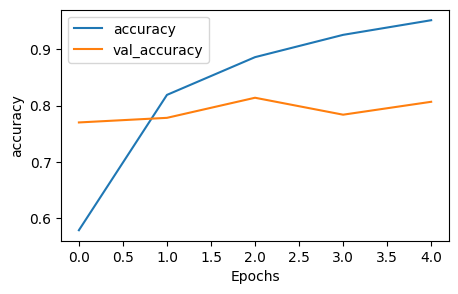

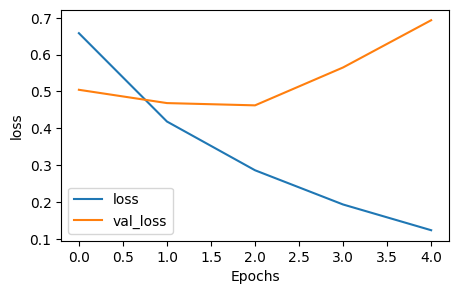

In [62]:
plot_graphs(history_srnn, "accuracy")
plot_graphs(history_srnn, "loss")

# График точности покажет, насколько хорошо модель обучалась. Если линия растёт, это значит, что модель становилась лучше.
# График потерь покажет, насколько хорошо модель уменьшают свои ошибки. Если линия падает, это значит, что модель делает меньше ошибок.
# Эти графики помогают понять, как модель обучалась и какие результаты были достигнуты.

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8089 - loss: 0.6847
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.79      0.83      0.81     12500
           1       0.82      0.78      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



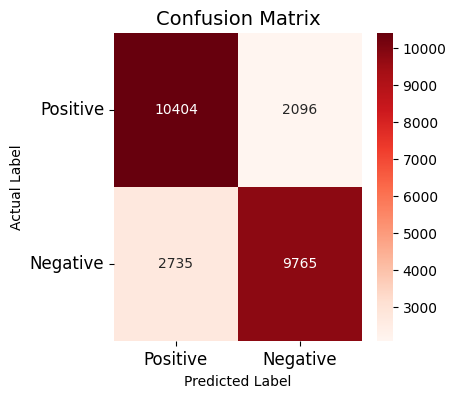

TP: 10404
TN: 9765
FP: 2096
FN: 2735


In [63]:
report(model_srnn)

In [64]:
# ↑
# Точность (accuracy) модели составляет 80.89%. Это означает, что модель правильно предсказывает 80.89% всех случаев.

# Потери (loss) модели равны 0.6847. Чем ниже это число, тем лучше, но здесь оно не идеальное.

# Precision (точность):
#   Для класса 0: 79% (из всех предсказанных 0, 81% действительно 0).
#   Для класса 1: 82% (из всех предсказанных 1, 82% действительно 1).

# Recall (полнота):
#   Для класса 0: 83% (из всех настоящих 0, модель правильно предсказала 83%).
#   Для класса 1: 78% (из всех настоящих 1, модель правильно предсказала 78%).

# F1-Score:
#   Для обоих классов около 0.81, что показывает, что модель хорошо сбалансирована между точностью и полнотой.

# TP (True Positives): 10,404 (Правильно предсказанные 1).
# TN (True Negatives): 9,765 (Правильно предсказанные 0).
# FP (False Positives): 2,096 (Ошибочно предсказанные 1 вместо 0).
# FN (False Negatives): 2,735 (Ошибочно предсказанные 0 вместо 1).

# Модель работает довольно хорошо, но можно улучшить её, снизив количество ошибочных предсказаний (FP и FN).

**BRNN(Bidirectional Recurrent Neural Network)**

In [65]:
# Задаём параметры для модели
max_features = 20000  # Максимальное количество уникальных слов
maxlen = 120  # Максимальная длина входной последовательности
embedding_vector_length = 32  # Размерность векторов для слов

# Определяем модель
model_brnn = tf.keras.Sequential([
    # Входной слой: преобразует слова в векторы размером 32
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    # Слой Dropout: случайно обнуляет 20% входных данных, чтобы избежать переобучения
    tf.keras.layers.Dropout(0.2),
    # Двунаправленный LSTM: извлекает информацию из последовательности в обоих направлениях
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # Полносвязный слой: 256 нейронов с ReLU активацией
    tf.keras.layers.Dense(units=256, activation='relu'),
    # Ещё один слой Dropout для предотвращения переобучения
    tf.keras.layers.Dropout(0.2),
    # Выходной слой: 1 нейрон с сигмоидной активацией для бинарной классификации
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Компилируем модель с функцией потерь и оптимизатором
model_brnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Создаём примерные входные данные для проверки модели
input_example = np.random.randint(0, vocab_size, (1, max_length))

# Построение модели на основе этих данных
model_brnn(input_example)

# Печатаем сводку модели, чтобы увидеть её структуру и параметры
model_brnn.summary()

# Модель: Использует LSTM в обе стороны для обработки текста, что позволяет лучше понимать контекст.
# Dropout: Помогает избежать переобучения, обнуляя случайные входные данные.
# Dense слои: Преобразуют данные в разные размеры и активации.
# Выходной слой: Используется для предсказания класса (0 или 1).
# Вывод: Модель может хорошо работать с текстовыми данными и должна показывать хорошие результаты в задаче бинарной классификации.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (1, 120, 16)                │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 120, 16)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (1, 64)                     │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 256)                    │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (1, 1)                      │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,441 (740.00 KB)

 Trainable params: 189,441 (740.00 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# ↑
# Embedding: Преобразует слова в векторы размером 16. У него 160,000 параметров.
# Dropout: Случайно обнуляет 20% данных в слоях, чтобы модель не переобучалась.
# Bidirectional LSTM: Работает с текстом в обоих направлениях и имеет 12,544 параметров.
# Dense слои:
# Первый Dense слой: 256 нейронов с активацией ReLU.
# Второй Dense слой: 1 нейрон для бинарной классификации.
# Вывод: Модель имеет 189,441 параметров и должна хорошо справляться с задачей бинарной классификации текста.


In [67]:
# Этот код запускает процесс обучения модели
history_brnn = model_brnn.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 34s 153ms/step - accuracy: 0.6163 - loss: 0.6134 - val_accuracy: 0.8132 - val_loss: 0.4131
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 30s 151ms/step - accuracy: 0.8720 - loss: 0.3106 - val_accuracy: 0.8306 - val_loss: 0.3994
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 48s 186ms/step - accuracy: 0.9023 - loss: 0.2509 - val_accuracy: 0.8195 - val_loss: 0.4193
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 34s 153ms/step - accuracy: 0.9200 - loss: 0.2103 - val_accuracy: 0.8170 - val_loss: 0.4274
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 159ms/step - accuracy: 0.9365 - loss: 0.1759 - val_accuracy: 0.8132 - val_loss: 0.4717


In [68]:
# ↑
# Точность (accuracy) модели растет: от 61.63% на первой эпохе до 93.65% на последней.
# Потери (loss) уменьшаются: от 0.6134 до 0.1759.

# Точность на валидации (val_accuracy) сначала растет, но затем начинает падать: от 83.06% до 81.32%.
# Потери на валидации (val_loss) сначала уменьшаются, а затем увеличиваются: от 0.3995 до 0.4717.

# Модель становится точнее на тренировочных данных, но может переобучаться, так как точность на валидационных данных начинает снижаться.
# Это может означать, что модель слишком сложная или требует доработки, например, регуляризации.

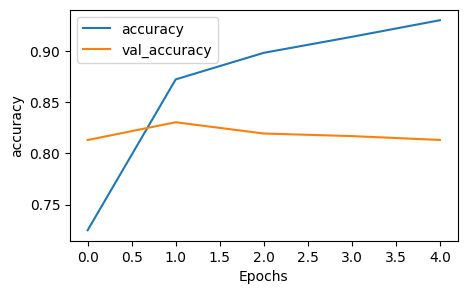

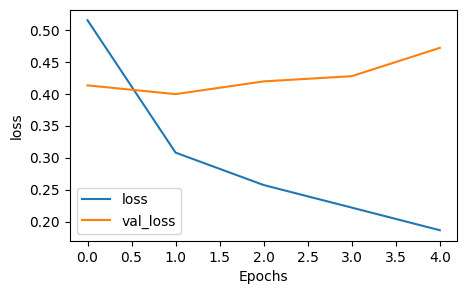

In [69]:
plot_graphs(history_brnn, "accuracy")
plot_graphs(history_brnn, "loss")

# График точности покажет, насколько хорошо модель обучалась. Если линия растёт, это значит, что модель становилась лучше.
# График потерь покажет, насколько хорошо модель уменьшают свои ошибки. Если линия падает, это значит, что модель делает меньше ошибок.
# Эти графики помогают понять, как модель обучалась и какие результаты были достигнуты.

782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8169 - loss: 0.4695
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.80      0.83      0.82     12500
           1       0.82      0.80      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



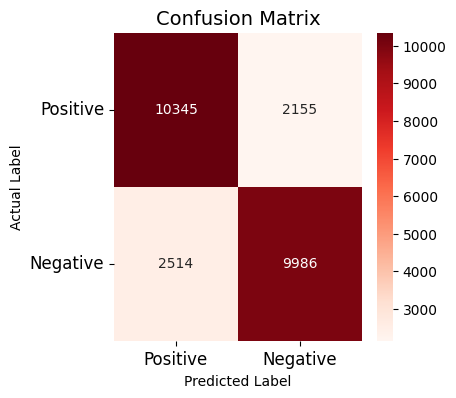

TP: 10345
TN: 9986
FP: 2155
FN: 2514


In [70]:
report(model_brnn)

In [71]:
# ↑
# Точность (accuracy) модели: 81.69%. Это означает, что модель правильно предсказывает класс в 81.69% случаев.
# Точность (precision) для класса 0: 80%, а для класса 1: 82%. Модель лучше распознает класс 1, чем класс 0.
# Полнота (recall) для класса 0: 83%, а для класса 1: 80%. Модель лучше находит примеры класса 0, чем класса 1.
# F1-оценка для класса 0: 82%, а для класса 1: 81%. Это средняя оценка точности и полноты.
# Число ошибок:
  # FP (ложно положительные): 2155. Модель ошибочно предсказывает класс 1, когда это класс 0.
  # FN (ложно отрицательные): 2514. Модель ошибочно предсказывает класс 0, когда это класс 1.
# Модель хорошо работает, но лучше распознает класс 0. Она делает больше ошибок на классе 1

**Deep BRNN**

In [72]:
max_features = 20000  # Максимальное количество уникальных слов, которые будем использовать
maxlen = 120  # Максимальная длина текста (слова). Тексты длиннее будут обрезаться
embedding_vector_length = 32  # Размер векторов для представления слов

# Определение модели
model_dbrnn = tf.keras.Sequential([ # Sigmoid: Функция активации для предсказания вероятности принадлежности к классу.
    # Преобразование слов в векторы фиксированной длины
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length),
    # Слой для случайного "выключения" некоторых нейронов, чтобы предотвратить переобучение
    tf.keras.layers.Dropout(0.25),
    # Двунаправленный LSTM, который обрабатывает текст с обеих сторон
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # Двунаправленный LSTM, который обрабатывает текст, учитывая всю последовательность
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # Полносвязный слой с 256 нейронами и функцией активации ReLU
    tf.keras.layers.Dense(units=256, activation='relu'),
    # Еще один слой Dropout для предотвращения переобучения
    tf.keras.layers.Dropout(0.2),
    # Полносвязный слой с 32 нейронами и функцией активации ReLU
    tf.keras.layers.Dense(units=32, activation='relu'),
    # Еще один слой Dropout
    tf.keras.layers.Dropout(0.2),
    # Выходной слой с одним нейроном и функцией активации sigmoid для бинарной классификации
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Настройка параметров обучения модели
model_dbrnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Примерные входные данные для создания модели
input_example = np.random.randint(0, vocab_size, (1, maxlen))

# Постройте модель на основе этих данных
model_dbrnn(input_example)

# Печать структуры модели
model_dbrnn.summary()

# Модель имеет сложную архитектуру с несколькими слоями, которые помогут ей хорошо работать с текстами.
# Двунаправленные LSTM и Dropout помогут ей захватывать сложные зависимости в тексте и избегать переобучения.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (1, 120, 32)                │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (1, 120, 32)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (1, 120, 128)               │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (1, 128)                    │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (1, 256)                    │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (1, 32)                     │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (1, 32)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 829,761 (3.17 MB)

 Trainable params: 829,761 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# ↑
# Общее количество параметров: Модель имеет 829,761 параметров. Эти параметры настраиваются во время обучения модели.
# Embedding (Встраивание): Преобразует слова в векторы длиной 32. Обрабатывает текст длиной до 120 слов.
# Bidirectional LSTM: Два слоя Bidirectional LSTM помогают модели понимать текст, читая его как слева направо, так и справа налево.
# Dense (Полносвязные слои): После LSTM идут полносвязные слои, которые помогают модели сделать окончательное предсказание.
# Dropout: Используется, чтобы модель не переобучалась, случайно "выключая" некоторые нейроны во время тренировки.

In [74]:
# Этот код запускает процесс обучения модели
history_dbrnn = model_dbrnn.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final), callbacks=[reduce_lr, epoch_callback])


Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 191s 937ms/step - accuracy: 0.6242 - loss: 0.6070 - val_accuracy: 0.8238 - val_loss: 0.3916 - learning_rate: 0.0010
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 201s 932ms/step - accuracy: 0.8784 - loss: 0.3071 - val_accuracy: 0.8128 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 202s 934ms/step - accuracy: 0.9099 - loss: 0.2372 - val_accuracy: 0.8194 - val_loss: 0.4057 - learning_rate: 0.0010
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.9416 - loss: 0.1698 - val_accuracy: 0.8154 - val_loss: 0.5005 - learning_rate: 2.0000e-04
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9527 - loss: 0.1386 - val_accuracy: 0.8145 - val_loss: 0.5041 - learning_rate: 2.0000e-04


In [75]:
# ↑
# Точность на тренировочных данных: Модель постепенно улучшала свою точность на тренировочных данных с 62.42% до 95.27% за 5 эпох.
# Потери на тренировочных данных: Потери (loss) уменьшались, что означает, что модель лучше справляется с задачей, обучаясь на тренировочных данных.
# Точность на валидационных данных: Точность на валидационных данных колебалась, начиная с 82.38% и достигая 81.45% к концу обучения.
# Это говорит о том, что модель может переобучаться (показывать хорошие результаты на тренировочных данных, но не всегда на новых данных).
# Потери на валидационных данных: Потери на валидационных данных увеличивались в последние эпохи, что также может указывать на переобучение.
# Изменение скорости обучения: В конце обучения скорость обучения была снижена. Это помогает модели лучше находить оптимальные параметры.

# Модель улучшалась на тренировочных данных, но имела некоторые колебания на валидационных данных, что может указывать на переобучение.
# Нужно следить за тем, чтобы модель не слишком сильно переобучалась и хорошо работала на новых данных.

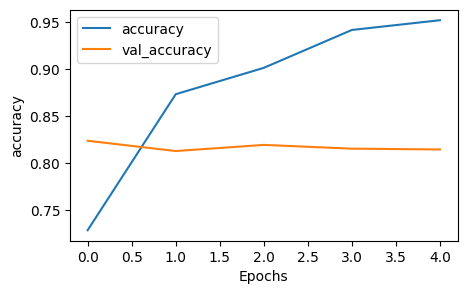

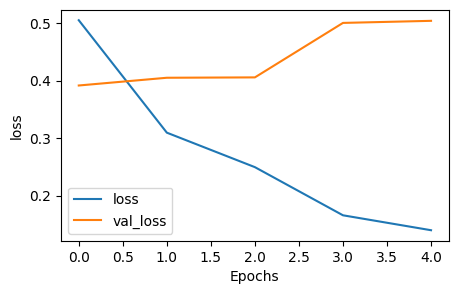

In [76]:
plot_graphs(history_dbrnn, "accuracy")
plot_graphs(history_dbrnn, "loss")

# График точности покажет, насколько хорошо модель обучалась. Если линия растёт, это значит, что модель становилась лучше.
# График потерь покажет, насколько хорошо модель уменьшают свои ошибки. Если линия падает, это значит, что модель делает меньше ошибок.
# Эти графики помогают понять, как модель обучалась и какие результаты были достигнуты.

782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.8187 - loss: 0.4966
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.80      0.84      0.82     12500
           1       0.83      0.79      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.82      0.81      0.81     25000
weighted avg       0.82      0.81      0.81     25000



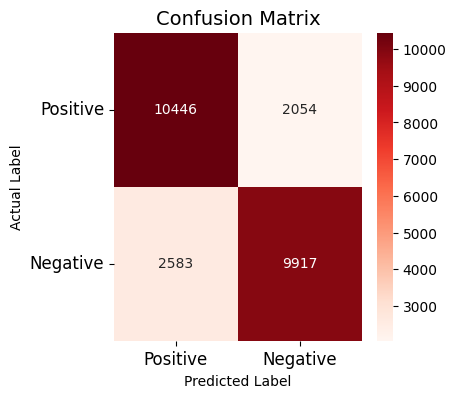

TP: 10446
TN: 9917
FP: 2054
FN: 2583


In [77]:
report(model_dbrnn)

In [78]:
# ↑
# Точность (Accuracy): 81.87%. Модель правильно классифицировала 81.87% всех примеров.

# Precision:
# Для класса 0: 80%. Это значит, что из всех предсказанных как 0, 80% действительно были 0.
# Для класса 1: 83%. Это значит, что из всех предсказанных как 1, 83% действительно были 1.

# Recall:
# Для класса 0: 84%. Это значит, что из всех настоящих 0, 84% были правильно предсказаны.
# Для класса 1: 79%. Это значит, что из всех настоящих 1, 79% были правильно предсказаны.

# F1-Score:
# Для класса 0: 82%. Это среднее значение precision и recall для класса 0.
# Для класса 1: 81%. Это среднее значение precision и recall для класса 1.

# TP (True Positives): 10446. Правильно предсказанных положительных примеров.
# TN (True Negatives): 9917. Правильно предсказанных отрицательных примеров.
# FP (False Positives): 2054. Неправильно предсказанных положительных примеров.
# FN (False Negatives): 2583. Неправильно предсказанных отрицательных примеров.

# Вывод: Модель работает хорошо, но у неё есть немного больше ошибок в предсказаниях для класса 1.
# Точность и F1-Score для обоих классов близки друг к другу, что говорит о сбалансированности модели.

In [79]:
# Мы создали и обучили разные типы рекуррентных нейронных сетей, сравним их эффективность:

# Вот краткий вывод из сравнения различных типов рекуррентных нейронных сетей:
# Flatten:
  # Тренировочная точность: 96.99%
  # Валидационная точность: 83.02%
  # Вывод: Хорошие результаты, но точность на валидации не всегда стабильна.

  # LSTM:
  # Тренировочная точность: 94.74%
  # Валидационная точность: 81.52%
  # Вывод: Хорошие результаты, но точность на валидации немного ниже, чем у Flatten.

# GRU:
  # Тренировочная точность: 93.42%
  # Валидационная точность: 81.68%
  # Вывод: Результаты сопоставимы с LSTM. Валидационная точность немного выше, но тренировочная точность ниже.

# Convolution RNN:
  # Тренировочная точность: 94.34%
  # Валидационная точность: 82.31%
  # Вывод: Хорошие результаты, тренировочная точность и точность на валидации немного выше, чем у GRU.

# SRNN:
  # Тренировочная точность: 95.49%
  # Валидационная точность: 80.68%
  # Вывод: Высокая тренировочная точность, но точность на валидации ниже, чем у других моделей.

# BRNN:
  # Тренировочная точность: 93.65%
  # Валидационная точность: 81.32%
  # Вывод: Тренировочная точность ниже, чем у других моделей. Точность на валидации не высокая.

# Deep BRNN:
  # Тренировочная точность: 95.27%
  # Валидационная точность: 81.45%
  # Вывод: Хорошие результаты, но точность на валидации немного ниже, чем у Flatten.


# Наилучшие результаты у модели Flatten и Deep BRNN по тренировочной точности, но у Flatten также лучше точность на валидации.
# LSTM и Convolution RNN показывают стабильные результаты с хорошей точностью на валидации.
# GRU и BRNN имеют немного худшие результаты по точности на валидации.
# Выбор модели зависит от важности точности на валидации и требований к скорости обучения и вычислительным ресурсам.

# Наилучшие результаты у модель Flatten по тренировочной точности и по точность на валидации.
# SRNN и Deep BRNN показывают высокие результаты на тренировочной точности
# GRU и Convolution RNN показывают стабильные результаты с хорошей точностью на валидации.
# LSTM, BRNN и Deep BRNN имеют немного худшие результаты по точности на валидации.
# Выбор модели зависит от важности точности на валидации и требований к скорости обучения и вычислительным ресурсам.

Наилучшие результаты у модели Flatten, SRNN и Deep BRNN по тренировочной точности, но у Flatten также лучше точность на валидации, а у SRNN самая низкая точность на валидации.


GRU и Convolution RNN показывают стабильные результаты с хорошей точностью на валидации.


LSTM, BRNN и Deep BRNN имеют немного худшие результаты по точности на валидации.


Выбор модели зависит от важности точности на валидации и требований к скорости обучения и вычислительным ресурсам.






